---

<h1>Classification - Recurrent Neural Network - Twitter Sentiment</h1>
<p>Hello Sarina
<br>
The Dataset I have chosen is the Twitter Sentiment Analysis dataset, taken from Sentiment140
    <ul>
        <li>This Dataset essentially contains multiple columns</li>
        <li>The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)</li>
        <li>The id of the tweet</li>
        <li>The date of the tweet </li>
        <li>The query. If there is no query, then this value is NO_QUERY</li>
        <li>The user that tweeted</li>
        <li>The text of the tweet</li>
    </ul>
<a href='http://help.sentiment140.com/for-students'>http://help.sentiment140.com/for-students</a>
</p>

---

## Table of Contents:
* [What / Why a Reccurent Neural Network](#what-why-rnn)
* [Imports](#imports)
* [Second Bullet Header](#second-bullet)

---

## What / Why a Recurrent Neural Network <a class="anchor" id="what-why-rnn"></a>
<p>
Recurrent Neural Networks (RNN) is more powerful / robust type of neural network. Like many other neural networks, it's conception began in the 1980's, however recent years has seen this neural network gain more popularity in the data science enviroment. What really makes RNN more special than it's other counter parts is it's use of Long Short-Term Memory (LSTM).
<br><br>
LSTM operate by learning in order dependence where the output of a previous step is used as an input in the current step. Because of this, RNN can remember important things about the input they received, which allows the neural network to be very precise in its prediction. This is what ultimately makes RNN the prefered choice for sequential data like time series, financial data, audio, video, weather and in the case of this notebook text / speech.
<br><br>
For the data set chosen for this notebook I will be using the text data of user's tweet to determine their sentiment within the tweet. This, I will be processing a massive dataset of large amounts of raw text. This means I will be peforming deep learning, so a neural netowrk will be the model and since my main feature will be the text data of the tweet, a Reccurent Neural Network will be the excat choice of the neural network needed.
</p>

---

## Imports <a class="anchor" id="imports"></a>

In [76]:
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from wordcloud import WordCloud

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [80]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [127]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [134]:
from IPython.display import display, HTML
import itertools

In [81]:
import tensorflow as tf
from keras import models
from keras import layers

# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [82]:
from sklearn.metrics import classification_report

## Second Bullet Header <a class="anchor" id="second-bullet"></a>

In [83]:
spark = SparkSession.builder.master('local').appName('TwitterSentimentAnalysis').config('spark.executer.memory', '6gb').getOrCreate()

In [84]:
url = 'C:/Users/Dylan/Desktop/Datasets/trainingandtestdata/training.1600000.processed.noemoticon.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='False').load(url).toDF('sentiment','id','date','query_string','user','text')

In [85]:
df.show()

+---------+----------+--------------------+------------+---------------+--------------------+
|sentiment|        id|                date|query_string|           user|                text|
+---------+----------+--------------------+------------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|    NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        0|1467810672|Mon Apr 06 22:19:...|    NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|    NO_QUERY|       mattycus|@Kenichan I dived...|
|        0|1467811184|Mon Apr 06 22:19:...|    NO_QUERY|        ElleCTF|my whole body fee...|
|        0|1467811193|Mon Apr 06 22:19:...|    NO_QUERY|         Karoli|@nationwideclass ...|
|        0|1467811372|Mon Apr 06 22:20:...|    NO_QUERY|       joy_wolf|@Kwesidei not the...|
|        0|1467811592|Mon Apr 06 22:20:...|    NO_QUERY|        mybirch|         Need a hug |
|        0|1467811594|Mon Apr 06 22:20:...|    NO_QUERY|    

In [87]:
pandasDF = df.toPandas()
pandasDF.shape

(1600000, 6)

In [88]:
pandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  object
 1   id            1600000 non-null  object
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: object(6)
memory usage: 73.2+ MB


sentiment       0
id              0
date            0
query_string    0
user            0
text            0
dtype: int64

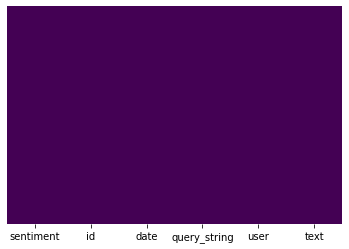

In [89]:
sns.heatmap(pandasDF.isnull(), yticklabels=False, cbar=False, cmap='viridis')
pandasDF.isnull().sum()

In [90]:
pandasDF['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [91]:
pandasDF.drop(['id','date','query_string','user'],axis=1,inplace=True)
pandasDF.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [92]:
lab_to_sentiment = {'0':'Negative', '4':'Positive'}
def label_decoder(label):
  return lab_to_sentiment[label]
pandasDF['sentiment'] = pandasDF['sentiment'].apply(lambda x: label_decoder(x))
pandasDF.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [93]:
pandasDF[pandasDF['sentiment'] == 'Negative'].head(10)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
5,Negative,@Kwesidei not the whole crew
6,Negative,Need a hug
7,Negative,@LOLTrish hey long time no see! Yes.. Rains a...
8,Negative,@Tatiana_K nope they didn't have it
9,Negative,@twittera que me muera ?


In [94]:
pandasDF[pandasDF['sentiment'] == 'Positive'].head(10)

,sentiment,text
800000,Positive,I LOVE @Health4UandPets u guys r the best!!
800001,Positive,im meeting up with one of my besties tonight! ...
800002,Positive,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,Positive,Being sick can be really cheap when it hurts t...
800004,Positive,@LovesBrooklyn2 he has that effect on everyone
800005,Positive,@ProductOfFear You can tell him that I just bu...
800006,Positive,@r_keith_hill Thans for your response. Ihad al...
800007,Positive,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,Positive,"@tommcfly ah, congrats mr fletcher for finally..."
800009,Positive,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [95]:
pandasDF.describe()

,sentiment,text
count,1600000,1600000
unique,2,1581466
top,Negative,isPlayer Has Died! Sorry
freq,800000,210


In [96]:
pandasDF.groupby('sentiment').describe()

text                                        
            count  unique                        top freq
sentiment                                                
Negative   800000  790185  isPlayer Has Died! Sorry   210
Positive   800000  793506              good morning   118

In [97]:
pandasDF['length'] = pandasDF['text'].apply(len)
pandasDF.head()

,sentiment,text,length
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,Negative,is upset that he can't update his Facebook by ...,111
2,Negative,@Kenichan I dived many times for the ball. Man...,89
3,Negative,my whole body feels itchy and like its on fire,47
4,Negative,"@nationwideclass no, it's not behaving at all....",111


<AxesSubplot:xlabel='length', ylabel='Count'>

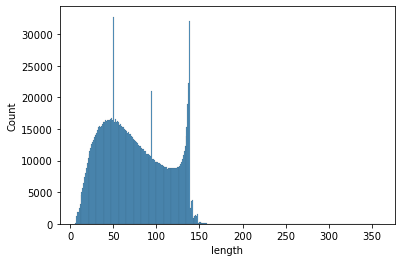

In [98]:
sns.histplot(pandasDF['length'])

In [99]:
pandasDF['length'].describe()

count    1.600000e+06
mean     7.404176e+01
std      3.638799e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.590000e+02
Name: length, dtype: float64

In [100]:
pandasDF[pandasDF['length'] == 3.590000e+02]['text'].iloc[0]

'5 days till new top gear  �?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?�'

array([<AxesSubplot:title={'center':'Negative'}>,
       <AxesSubplot:title={'center':'Positive'}>], dtype=object)

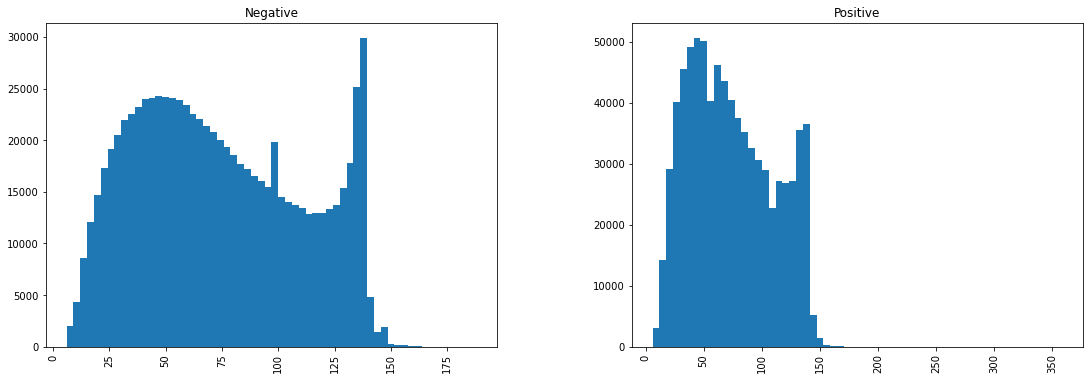

In [101]:
pandasDF.hist(column='length', by='sentiment', bins=60, figsize=(18,6))

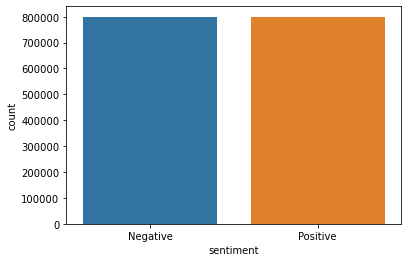

In [102]:
X_axis = ['sentiment']
for col in X_axis:
    sns.countplot(data=pandasDF, x=col)
    plt.show()

(0.0, 260.0)

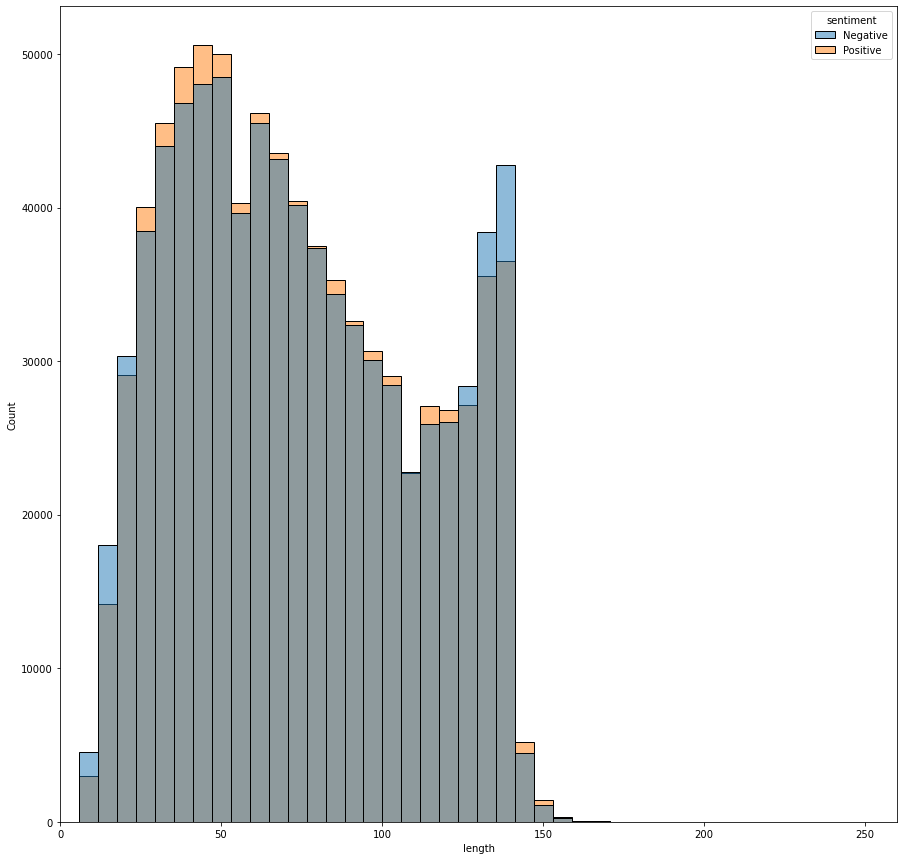

In [103]:
fig, ax = plt.subplots(figsize=(15,15))
sns.histplot(
    data=pandasDF, x='length', hue=pandasDF['sentiment'],
    bins=60, ax=ax
)
ax.set_xlim([0, 260])

In [104]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [105]:
stemmer = SnowballStemmer('english')

In [106]:
text_cleaning_regex = '@S+|https?:S+|http?:S|[^A-Za-z0-9]+'

In [107]:
def clean_tweets(text, stem=False):
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Passed to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [108]:
pandasDF.drop(['length'],axis=1,inplace=True)
pandasDF['text'] = pandasDF['text'].apply(lambda x: clean_tweets(x))

In [109]:
pandasDF.head()

,sentiment,text
0,Negative,switchfoot http twitpic com 2y1zl awww bummer ...
1,Negative,upset update facebook texting might cry result...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving mad see


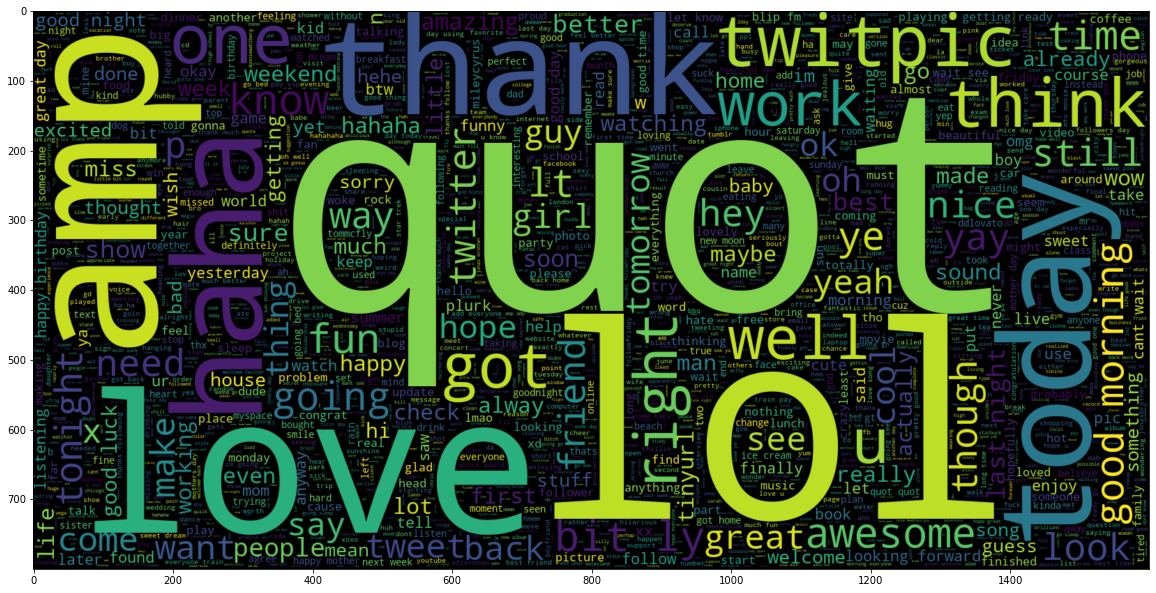

In [110]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(pandasDF[pandasDF['sentiment'] == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

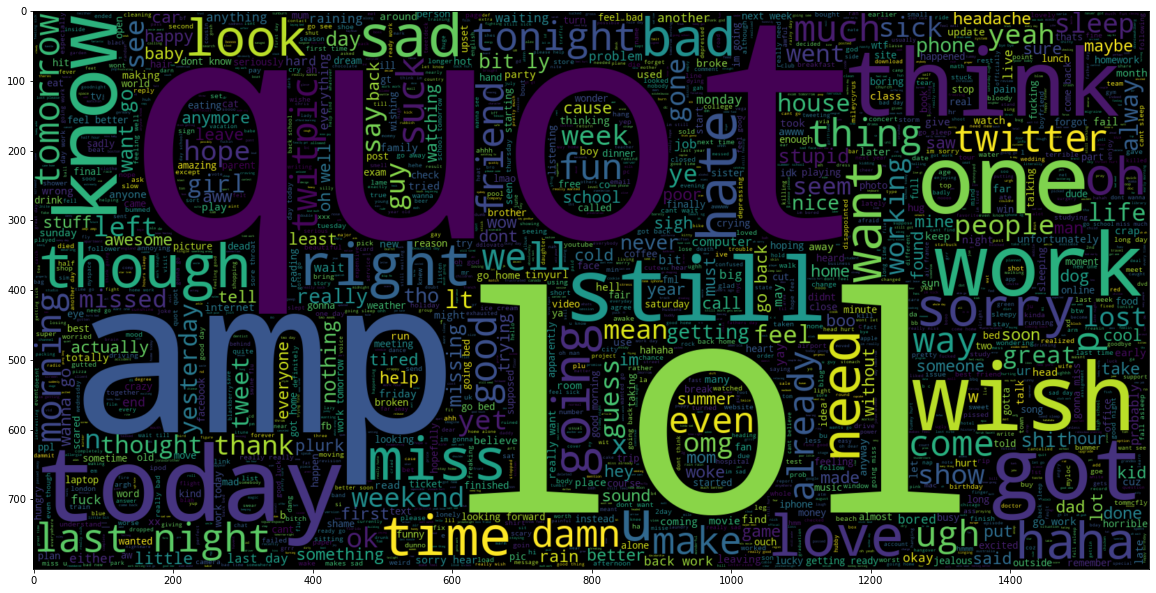

In [111]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(pandasDF[pandasDF['sentiment'] == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [112]:
#Splitting the data
train_data, test_data = train_test_split(pandasDF, test_size=0.2)
print('Train Data size:',len(train_data))
print('Test Data size:',len(test_data))

Train Data size: 1280000
Test Data size: 320000


In [113]:
train_data.head(10)

,sentiment,text
51935,Negative,dropped second game played poor oh well 2nd pl...
309870,Negative,aplusk time difference terrible miss everything
1111016,Positive,finally bought decent digital portable tv hurr...
1213154,Positive,got back home sleep
356867,Negative,grad practice omg finally hitting seeing sign
1267792,Positive,got lakers tickets game 2 weekend nadia oh sna...
654991,Negative,damn missed dwight twitter yesterday ughhh
1290631,Positive,go watch quot mystery movie quot ooooo hopeful...
996795,Positive,izzy marie hahahahaha welcome
207103,Negative,taylorswift13 read blog hilarious haha made ro...


In [114]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 565401


In [115]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen=30)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen=30)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [116]:
labels = train_data.sentiment.unique().tolist()

In [117]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [118]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('C:/Users/Dylan/Desktop/VC-Material/PDAN8412/PDAN8412_work/DylanAdimoolumST10133110_POE/Part1-RNN/glove.6B/glove.6B.300d.txt', encoding="utf8")
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [119]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [120]:
embedding_layer = layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

In [121]:
sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [150]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           169620300 
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [122]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

In [124]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 668s 532ms/step - loss: 0.5194 - accuracy: 0.7392 - val_loss: 0.4835 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 704s 563ms/step - loss: 0.4880 - accuracy: 0.7622 - val_loss: 0.4728 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 710s 568ms/step - loss: 0.4770 - accuracy: 0.7693 - val_loss: 0.4685 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 711s 569ms/step - loss: 0.4706 - accuracy: 0.7731 - val_loss: 0.4652 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 719s 575ms/step - loss: 0.4664 - accuracy: 0.7754 - val_loss: 0.4630 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 729s 583ms/step - loss: 0.4625 - accuracy: 0.7785 - val_loss: 0.4663 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 7/10
1250/1250 [============

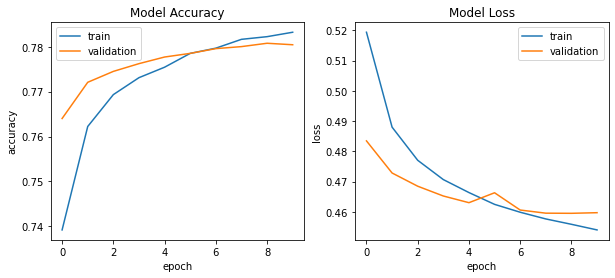

In [151]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [126]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 36s 1s/step


In [154]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

----------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    160411
    Positive       0.77      0.79      0.78    159589

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

----------------------------------------------------------------


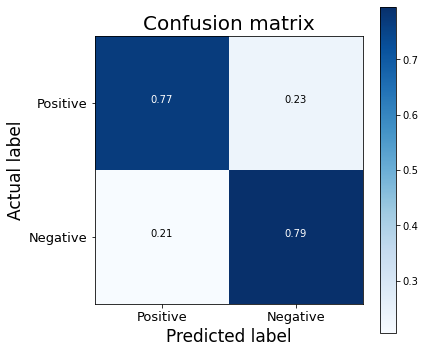

In [155]:
display(HTML("<h1>RNN Model</h1>"))
# Getting and printing model scores
print('----------------------------------------------------------------')
print(classification_report(list(test_data.sentiment), y_pred_1d))
print('----------------------------------------------------------------')
# Look at classification report to evaluate the model
# Using graph definitions made earlier
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()